### Analyzing the creativity of the premier league players 

We use the statbombs data to analyze the creativity of the players of the English premier league (EPL) 2019-20 season. The data is scrapred from fbref.com which uses the statbombs data

In [105]:
# import the libraries required
import requests
from bs4 import BeautifulSoup
import pandas as pd
import re
import sys, getopt
import csv
import numpy as np
import matplotlib.pyplot as plt

In [37]:
# get the data-stat features used in the table as a list
def get_features(rows_squad):
    player_feature = []
    for row in rows_squad:
        tds = row.find_all('td')
        for i in tds:
            a = str(i).split(' ')
            for j in a:
                if "data-stat" in j:
                    player_feature.append(j.split('"')[1])
        break
    return player_feature

def rmcomma(s):
        return s.replace(",", "")

def first_name(name):
    return name.split(' ')[0]

def second_name(i):
    return i.split(" ")[-1]

In [35]:
# use this function while scraping the players of the single team 
def get_full_data(url, table_number):
    
    """
    input parameters 
    
    url - url of the page
    table_number - appropriate table number (zero indexed)
    
    Note: table number may change as per the pages double check
    
    """

    # load the page
    res = requests.get(url)
    comm = re.compile("<!--|-->")
    soup = BeautifulSoup(comm.sub("",res.text),'lxml')
    
    # get all the tables
    all_tables = soup.findAll("tbody")
    
    # get the desired table
    player_table = all_tables[table_number]
    rows_squad = player_table.find_all('tr')
    
    # get all the features 
    player_features = get_features(rows_squad)


    
    # dictionary to lod the player fetures - columns of the tables
    features_wanted_player = {}
    for i in player_features:
        features_wanted_player[i] = []
        
    #dictionary to load the result
    pre_df_squad = {}

    for row in rows_squad:
        if(row.find('th',{"scope":"row"}) != None):
            name = row.find('th', {"data-stat":"player"}).text.strip().encode().decode("utf-8")
            if "player" in pre_df_squad:
                pre_df_squad['player'].append(name)
            else:
                pre_df_squad['player'] = [name]

            for f in features_wanted_player:
                cell = row.find("td",{"data-stat": f})
                if cell is not None:
                    text = cell.text
                if f in pre_df_squad:
                    pre_df_squad[f].append(text)
                else:
                    pre_df_squad[f] = [text]
    
    # create a dataframe from the dictionary
    rdf = pd.DataFrame(pre_df_squad)
    
    # drop the mathches column
    rdf = rdf.drop('matches', 1)
    
    cols = rdf.columns
    
    # iterate over the columns and change numeric strings values to numneric values
    for i in cols[3:]:
        rdf[i] = rdf[i].apply(pd.to_numeric)
        
    # return the dataframe
    return rdf

In [66]:
# use this funciton while scraping the full player of leagues 
def full_player_data(url, table_number):
    
    """
    input parameters 
    
    url - url of the page
    table_number - appropriate table number (zero indexed)
    
    Note: table number may change as per the pages double check
    
    """
    
    # load the page
    res = requests.get(url)
    comm = re.compile("<!--|-->")
    soup = BeautifulSoup(comm.sub("",res.text),'lxml')
    
    # get all the tables of the page
    all_tables = soup.findAll("tbody")
    
    #choose the table providing the appropriate index
    player_table = all_tables[table_number]
    
    #get all the rows of the table
    rows_squad = player_table.find_all('tr')
    player_features = get_features(rows_squad)
    features_wanted_player = {}
    
    for i in player_features:
        features_wanted_player[i] = []
    pre_df_squad = {}
    
    for row in rows_squad:
        if(row.find('th',{"scope":"row"}) != None):
            name = row.find('th', {"data-stat":"player"})
            if name is not None:
                if "player" in pre_df_squad:
                    pre_df_squad['player'].append(name)
                else:
                    pre_df_squad['player'] = [name]

            for f in features_wanted_player:
                cell = row.find("td",{"data-stat": f})
                if cell is not None:
                    text = cell.text
                if f in pre_df_squad:
                    if text != "None":
                        pre_df_squad[f].append(text)
                else:
                    pre_df_squad[f] = [text]
                    
    rdf = pd.DataFrame(pre_df_squad)
    cols = rdf.columns
    
    if "matches" in cols:
        rdf = rdf.drop("matches", 1)
        
    cols = rdf.columns
    
    for i in cols[4:]:
        rdf[i] = rdf[i].apply(pd.to_numeric)
    return rdf

In [67]:
# url
pl1920 = "https://fbref.com/en/comps/9/3232/gca/2019-2020-Premier-League-Stats"

# function call 
g2 = full_player_data(pl1920, 1)

Index(['player', 'nationality', 'position', 'squad', 'age', 'birth_year',
       'minutes_90s', 'sca', 'sca_per90', 'sca_passes_live', 'sca_passes_dead',
       'sca_dribbles', 'sca_shots', 'sca_fouled', 'gca', 'gca_per90',
       'gca_passes_live', 'gca_passes_dead', 'gca_dribbles', 'gca_shots',
       'gca_fouled', 'gca_og_for', 'matches'],
      dtype='object')


Description of Columns names
PLAYER
1. player -> Player name
2. nationality -> Nationality of the player
3. position -> Dominant position
4. squad -> Current team
5. age -> Age of the player
6. birth_year -> Birth year

PLAYED
1. minutes_90s -> Minutes played per 90 minutes

SHOTS CREATING
1. sca -> Shot creating acitons
2. sca_per90 -> Shot creating acitons per 90 miuutes
3. sca_passes_live -> Completed live passes that lead to the shot attempt
4. sca_passes_dead -> Completed dead-ball passes that lead to the shot attempt (includes free kicks, corner kicks, kick offs, throw-ins, and goal-kicks)
5. sca_dribbles -> Successful dribbles that lead to shot attempt
6. sca_shots -> Shots that lead to another shot attempt
7. sca_fouled -> Fouls drawn that lead to the shot attempt

GOALS CREATING
1. gca -> Goal creating actions
2. gca_per90 -> Goal creating actions per 90 minutes
3. gca_passes_live -> Completed  passes that lead to the goal attempt
4. gca_passes_dead -> Completed dead-ball passes that lead to the goal attempt (includes free kicks, corner kicks, kick offs, throw-ins, and goal-kicks)
5. gca_dribbles -> Successful dribbles that lead to the goal attempt
6. gca_shots -> Shots that lead to the goal attempt
7. gca_fouled -> Fouls drawn that lead to the goal attempt
8. gca_og_for -> Actions that directly lead opponent scoring own goal

In [68]:
# filter out the players who have player more than 500 minutes 
g2_minutes5 = g2.loc[g2.minutes_90s >= 5.55]

In [69]:
# let's see the stats only for the GoalKeepers
gk = g2_minutes5.loc[g2_minutes5.position == "GK"]

In [70]:
print(gk["sca_per90"].mean())
print(gk["gca_per90"].mean())

0.09518518518518518
0.011851851851851851


In [72]:
#remove the GoalKeppers from the analysis
g2_minutes5 = g2_minutes5.loc[g2.position != "GK"]

In [74]:
sca_mean = g2_minutes5["sca_per90"].mean()
gca_mean = g2_minutes5["gca_per90"].mean()

print(sca_mean)
print(gca_mean)

1.8902997275204354
0.21010899182561327


In [81]:
g2_minutes5

,player,nationality,position,squad,age,birth_year,minutes_90s,sca,sca_per90,sca_passes_live,...,sca_shots,sca_fouled,gca,gca_per90,gca_passes_live,gca_passes_dead,gca_dribbles,gca_shots,gca_fouled,gca_og_for
0,Patrick van Aanholt,nl NED,DF,Crystal Palace,28.0,1990.0,27.9,62.0,2.23,32.0,...,2.0,2.0,5.0,0.18,3.0,1.0,1.0,0.0,0.0,0.0
1,Max Aarons,eng ENG,DF,Norwich City,19.0,2000.0,36.0,54.0,1.50,42.0,...,3.0,4.0,3.0,0.08,1.0,1.0,0.0,0.0,1.0,0.0
2,Tammy Abraham,eng ENG,FW,Chelsea,21.0,1997.0,24.6,47.0,1.91,33.0,...,6.0,2.0,10.0,0.41,4.0,0.0,3.0,2.0,1.0,0.0
3,Che Adams,eng ENG,FW,Southampton,23.0,1996.0,12.3,24.0,1.94,15.0,...,2.0,4.0,5.0,0.41,2.0,0.0,1.0,0.0,2.0,0.0
5,Sergio Agüero,ar ARG,FW,Manchester City,31.0,1988.0,16.1,51.0,3.16,28.0,...,9.0,5.0,8.0,0.50,4.0,0.0,1.0,2.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
516,Pablo Zabaleta,ar ARG,DF,West Ham,34.0,1985.0,6.6,5.0,0.76,5.0,...,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0
517,Wilfried Zaha,ci CIV,"MF,FW",Crystal Palace,26.0,1992.0,36.4,105.0,2.88,62.0,...,5.0,15.0,8.0,0.22,4.0,0.0,0.0,1.0,2.0,1.0
518,Christoph Zimmermann,de GER,DF,Norwich City,26.0,1993.0,15.9,1.0,0.06,1.0,...,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0
519,Oleksandr Zinchenko,ua UKR,DF,Manchester City,22.0,1996.0,14.2,31.0,2.19,30.0,...,0.0,0.0,3.0,0.21,3.0,0.0,0.0,0.0,0.0,0.0


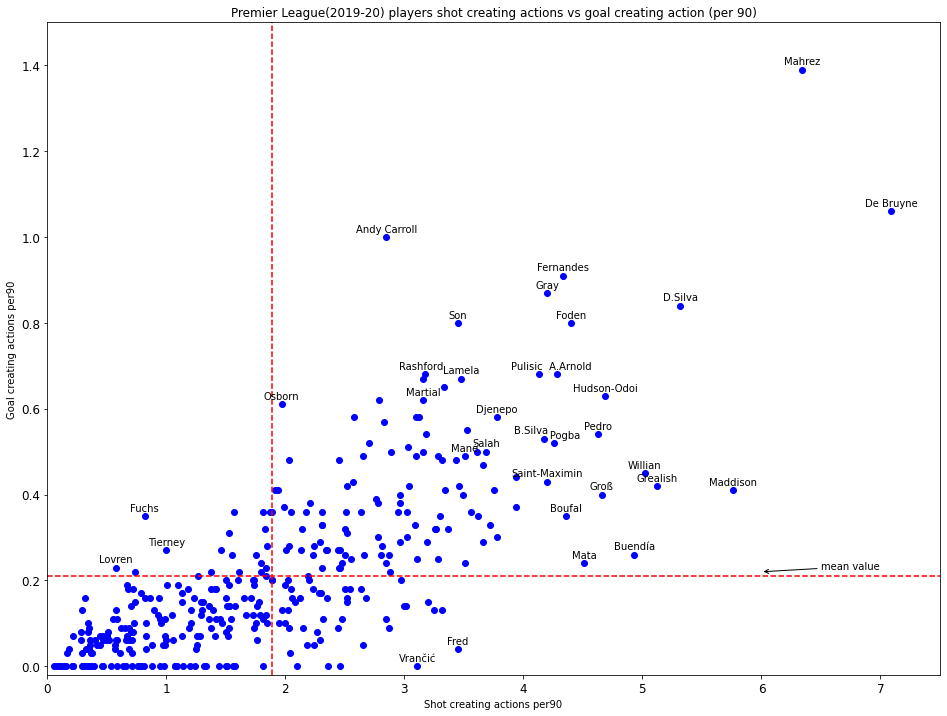

In [103]:
fig, ax = plt.subplots(figsize=(16,12))
ax.margins(0)

# Let's get the second name of the players for lableing purpose
Player = g2_minutes5["player"].apply(second_name)

# scatter plot
ax.scatter(g2_minutes5["sca_per90"], g2_minutes5["gca_per90"], color = "blue", edgecolor='face')


# lets label some of the points that seem interesting
# this is done is hit and trail basis since labeling all the points is not possible let's label as much as possible
for x,y,z,zp in zip(g2_minutes5["sca_per90"], g2_minutes5["gca_per90"], Player, g2_minutes5["player"]):
    if y > 0.8 or x > 5:
        label = zp
    else:
        label = ""
    if y < 0.8 and x > 4:
        label = z
        if label == "Silva":
            label = "B.Silva        "
        if label == "Pogba":
            label = "       Pogba"
    if x > 3.4 and y > 0.55:
        label = z
        if label == "Heung-min":
            label = "Son"
        if label == "Silva":
            label = "D.Silva"
        if label == "Alexander-Arnold":
            label = "         A.Arnold"
        if label == "Pulisic":
            label = "Pulisic        "
        if label == "Bruyne":
            label = "De Bruyne"
    if y>0.55 and x<2:
        label = z
    if y<0.1 and x>3:
        label = z
    if z=="Martial":
        label = z
    if z=="Mané":
        label = z
    if z=="Salah":
        label = z
    if z=="Rashford":
        label = "Rashford  "
    if z =="Robertson":
        lable = "Robertson"
    if x > 3.4:
        lable = z
    if y>0.22 and x<1.1:
        label = z
    
    # this method is called for each point
    ax.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,5), # distance from text to points (x,y)
                 ha='center')
    

# ax.scatter([sca_mean], [gca_mean], c='black', s=60)
# ax.annotate('Average player', xy=(sca_mean, gca_mean), xytext=(sca_mean-1, gca_mean+0.3),
#             arrowprops=dict(arrowstyle='->'))

# lableing the mean value
ax.annotate("mean value", xy=(6, 0.22), xytext=(6.5, 0.225), arrowprops=dict(arrowstyle='->'))

# Draw a line to represent the mean values of the each axis 
ax.plot([0, 7.5], [gca_mean, gca_mean], 'r--', label='Random guess')
ax.plot([sca_mean, sca_mean], [-0.02, 1.5], 'r--', label='Random guess')

# labeling the xaxis and yaxis and the title of the plot 
ax.set(xlabel = "Shot creating actions per90", ylabel="Goal creating actions per90", title="Premier League(2019-20) players shot creating actions vs goal creating action (per 90)")

# set the font of the ticks 
ax.tick_params(axis='both', which='major', labelsize=12)

# save the figure as a .png file in the current directory 
fig.savefig('goal_creation_vs_shot_creation_PL(12-20).png')

In [101]:
# can use any of the following styles to chage the background of the plot
print(plt.style.available)

['Solarize_Light2', '_classic_test_patch', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn', 'seaborn-bright', 'seaborn-colorblind', 'seaborn-dark', 'seaborn-dark-palette', 'seaborn-darkgrid', 'seaborn-deep', 'seaborn-muted', 'seaborn-notebook', 'seaborn-paper', 'seaborn-pastel', 'seaborn-poster', 'seaborn-talk', 'seaborn-ticks', 'seaborn-white', 'seaborn-whitegrid', 'tableau-colorblind10']
